Attempting to load historical data from: SET 50 Historical Data (6).csv
Successfully loaded data from SET 50 Historical Data (6).csv
Historical data (last 5 days):
Date
2025-05-07    793.73
2025-05-08    783.61
2025-05-09    789.38
2025-05-13    789.97
2025-05-14    793.90
Name: Price, dtype: float64

Calculating drift and volatility...
Initial Price (S0): 793.90
Annual Drift (mu): -0.0363 (-3.63%)
Annual Volatility (sigma): 0.1360 (13.60%)

Running Monte Carlo simulation for 1 years with 1000 paths...

Statistics of simulated prices at the end of year 1:
  Average Price: 765.18
  Median Price: 761.52
  90% Confidence Interval (5th to 95th percentile): 601.70 to 944.38


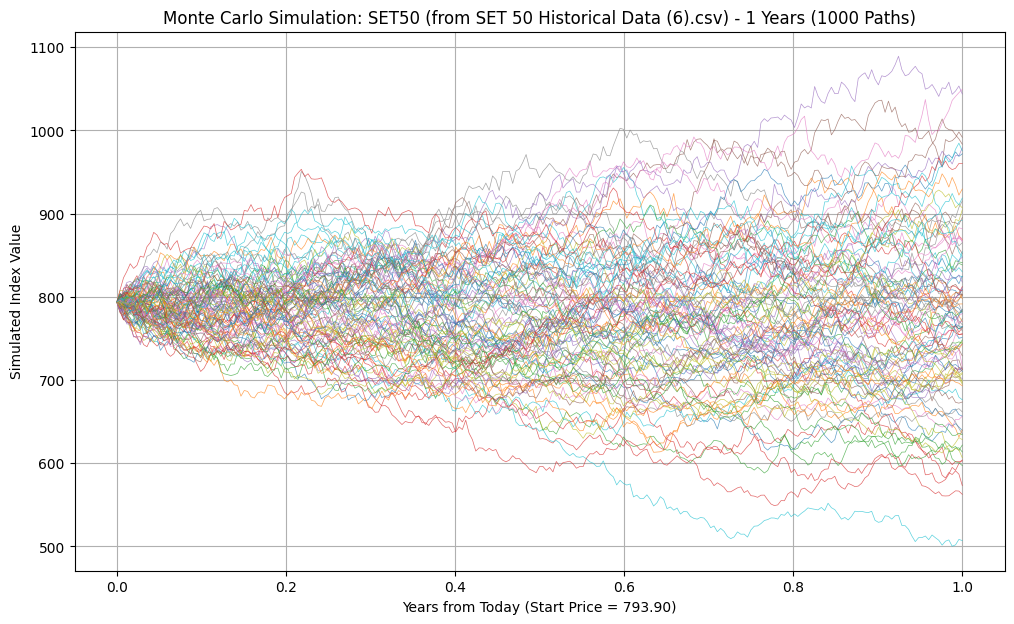

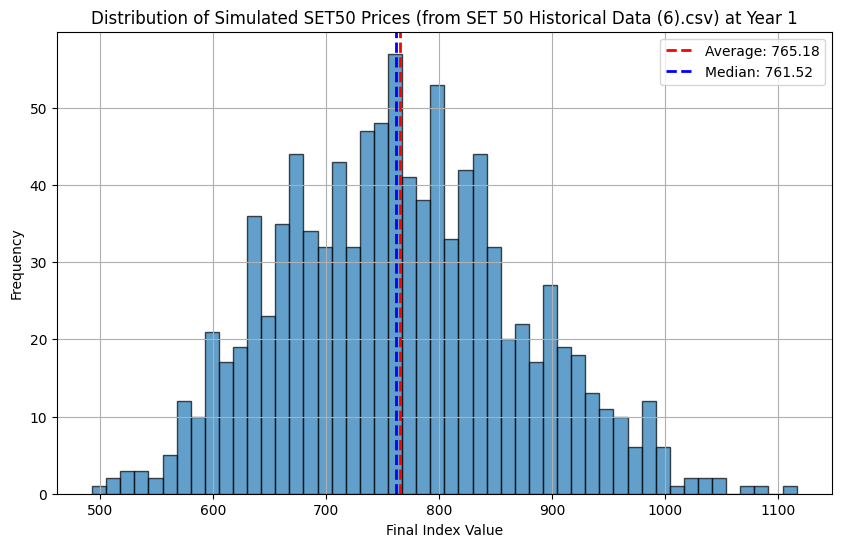

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from datetime import datetime, timedelta
os.chdir('/Users/fulinq/Documents/SET_Intern/SOMC/TradingData')

# --- 1. Setup and Data Acquisition ---
def get_historical_data_from_csv(csv_file_path, date_column='Date', price_column='Last'):
    """
    Loads historical closing prices from a CSV file.

    Parameters:
    csv_file_path (str): The full path to your CSV file.
    date_column (str): The name of the column containing dates.
    price_column (str): The name of the column containing closing prices.

    Returns:
    pandas.Series: A Series of closing prices indexed by date, or None if an error occurs.
    """
    try:
        # Read the CSV file
        # Pandas should be able to infer the date format.
        # If dates are in DD/MM/YYYY or MM/DD/YYYY, parse_dates should handle it.
        # If specific parsing is needed (e.g. for '2/1/2019' which might be M/D/YYYY or D/M/YYYY
        # depending on locale, though pandas often gets it right), you can add format hints.
        df = pd.read_csv(csv_file_path, parse_dates=[date_column])
        
        # Set the date column as the index
        df = df.set_index(date_column)
        
        # Ensure the index is sorted chronologically
        df = df.sort_index()
        
        # Select the price column
        prices = df[price_column]
        
        # The 'Last' column in your image might have commas (e.g., "1,000.50").
        # We need to remove them before converting to numeric.
        if prices.dtype == 'object': # Check if the column is read as strings
            prices = prices.str.replace(',', '', regex=False)

        # Convert to numeric, coercing errors will turn non-numeric values into NaN
        prices = pd.to_numeric(prices, errors='coerce')
        
        # Drop any NaN values that might have resulted from coercion or were already present
        prices = prices.dropna()
        
        if prices.empty:
            print(f"No valid price data found in column '{price_column}' after processing.")
            return None
            
        print(f"Successfully loaded data from {csv_file_path}")
        return prices
    except FileNotFoundError:
        print(f"Error: The file '{csv_file_path}' was not found. Make sure it's in the same directory or provide the full path.")
        return None
    except KeyError as e:
        print(f"Error: Column not found in CSV. Please ensure that the column names '{date_column}' and '{price_column}' exist in your CSV. Details: {e}")
        return None
    except Exception as e:
        print(f"An error occurred while reading or processing the CSV file: {e}")
        return None

# --- 2. Calculating Statistics ---
def calculate_drift_volatility(prices):
    """
    Calculates drift and volatility from price data.
    """
    if not isinstance(prices, pd.Series):
        print("Error: Input 'prices' must be a pandas Series.")
        return None, None, None
        
    log_returns = np.log(prices / prices.shift(1))
    log_returns = log_returns.dropna() 

    if log_returns.empty:
        print("Error: Not enough data to calculate log returns (need at least 2 data points).")
        return None, None, None

    mu_daily = log_returns.mean()
    sigma_daily = log_returns.std()

    trading_days = 252 # Assuming 252 trading days per year
    mu_annual = mu_daily * trading_days
    sigma_annual = sigma_daily * np.sqrt(trading_days)

    if pd.isna(mu_annual) or pd.isna(sigma_annual) or prices.empty or pd.isna(prices.iloc[-1]):
        print("Error: Calculated drift, volatility, or S0 is NaN. Check input data quality and length.")
        return None, None, None
        
    return mu_annual, sigma_annual, prices.iloc[-1]

# --- 3. Monte Carlo Simulation (GBM) ---
def monte_carlo_simulation(S0, mu, sigma, T_years, dt, num_simulations):
    """
    Runs Monte Carlo simulation using Geometric Brownian Motion.
    """
    num_steps = int(T_years / dt) 
    
    simulation_paths = np.zeros((num_steps + 1, num_simulations))
    simulation_paths[0, :] = S0 

    for t in range(1, num_steps + 1):
        Z = np.random.standard_normal(num_simulations) 
        simulation_paths[t, :] = simulation_paths[t-1, :] * np.exp((mu - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z)
        simulation_paths[t, :] = np.maximum(0, simulation_paths[t, :]) # Ensure prices don't go below zero

    return simulation_paths

# --- Main Settings ---
# This should be the name of your uploaded CSV file.
# Ensure this file is in the same directory as your Python script,
# or provide the full path to the file.
csv_file_name = 'SET 50 Historical Data (6).csv' 

# Column names from your CSV file (as seen in the image)
date_column_name = 'Date'
price_column_name = 'Price'

simulation_horizon_years = 1 
num_simulation_paths = 1000
trading_days_per_year = 252

# --- Execution ---
print(f"Attempting to load historical data from: {csv_file_name}")
historical_prices = get_historical_data_from_csv(csv_file_name, 
                                                 date_column=date_column_name, 
                                                 price_column=price_column_name)

if historical_prices is not None and not historical_prices.empty:
    print("Historical data (last 5 days):")
    print(historical_prices.tail())

    print("\nCalculating drift and volatility...")
    if len(historical_prices) < 2: # Need at least two data points to calculate returns
        print("Error: Not enough historical data points to calculate drift and volatility (need at least 2).")
    else:
        mu, sigma, S0 = calculate_drift_volatility(historical_prices)

        if mu is not None and sigma is not None and S0 is not None:
            print(f"Initial Price (S0): {S0:.2f}")
            print(f"Annual Drift (mu): {mu:.4f} ({(mu*100):.2f}%)")
            print(f"Annual Volatility (sigma): {sigma:.4f} ({(sigma*100):.2f}%)")

            dt = 1/trading_days_per_year

            print(f"\nRunning Monte Carlo simulation for {simulation_horizon_years} years with {num_simulation_paths} paths...")
            simulated_price_paths = monte_carlo_simulation(S0, mu, sigma, simulation_horizon_years, dt, num_simulation_paths)

            # --- 4. Displaying Results ---
            plt.figure(figsize=(12, 7))
            num_paths_to_plot = min(100, num_simulation_paths) # Plot a subset to keep the graph readable
            time_axis = np.linspace(0, simulation_horizon_years, simulated_price_paths.shape[0])

            for i in range(num_paths_to_plot):
                plt.plot(time_axis, simulated_price_paths[:, i], lw=0.5, alpha=0.7)

            plt.title(f'Monte Carlo Simulation: SET50 (from {csv_file_name}) - {simulation_horizon_years} Years ({num_simulation_paths} Paths)')
            plt.xlabel(f'Years from Today (Start Price = {S0:.2f})')
            plt.ylabel('Simulated Index Value')
            plt.grid(True)
            
            final_prices = simulated_price_paths[-1, :]
            avg_final_price = np.mean(final_prices)
            median_final_price = np.median(final_prices)
            percentile_5th = np.percentile(final_prices, 5)
            percentile_95th = np.percentile(final_prices, 95)

            print(f"\nStatistics of simulated prices at the end of year {simulation_horizon_years}:")
            print(f"  Average Price: {avg_final_price:.2f}")
            print(f"  Median Price: {median_final_price:.2f}")
            print(f"  90% Confidence Interval (5th to 95th percentile): {percentile_5th:.2f} to {percentile_95th:.2f}")
            plt.show()

            plt.figure(figsize=(10, 6))
            plt.hist(final_prices, bins=50, edgecolor='black', alpha=0.7)
            plt.title(f'Distribution of Simulated SET50 Prices (from {csv_file_name}) at Year {simulation_horizon_years}')
            plt.xlabel('Final Index Value')
            plt.ylabel('Frequency')
            plt.axvline(avg_final_price, color='red', linestyle='dashed', linewidth=2, label=f'Average: {avg_final_price:.2f}')
            plt.axvline(median_final_price, color='blue', linestyle='dashed', linewidth=2, label=f'Median: {median_final_price:.2f}')
            plt.legend()
            plt.grid(True)
            plt.show()
        else:
            print("Could not proceed with simulation due to errors in calculating drift/volatility. Please check data quality.")
else:
    print("Cannot proceed with simulation due to issues loading or processing historical data from the CSV file.")

Attempting to load historical data from: SET 50 Historical Data (6).csv
Successfully loaded data from SET 50 Historical Data (6).csv
Historical data (last 5 days):
Date
2025-05-07    793.73
2025-05-08    783.61
2025-05-09    789.38
2025-05-13    789.97
2025-05-14    793.90
Name: Price, dtype: float64

Calculating historical daily return statistics...
Last Price (S0): 793.90
Mean Daily Return: -0.000107 (-0.0107%)
Std Dev of Daily Return: 0.008566 (0.8566%)

Running Monte Carlo simulation for 5 years with 1000 paths...
Daily returns will be constrained between -30.0% and 30.0%.


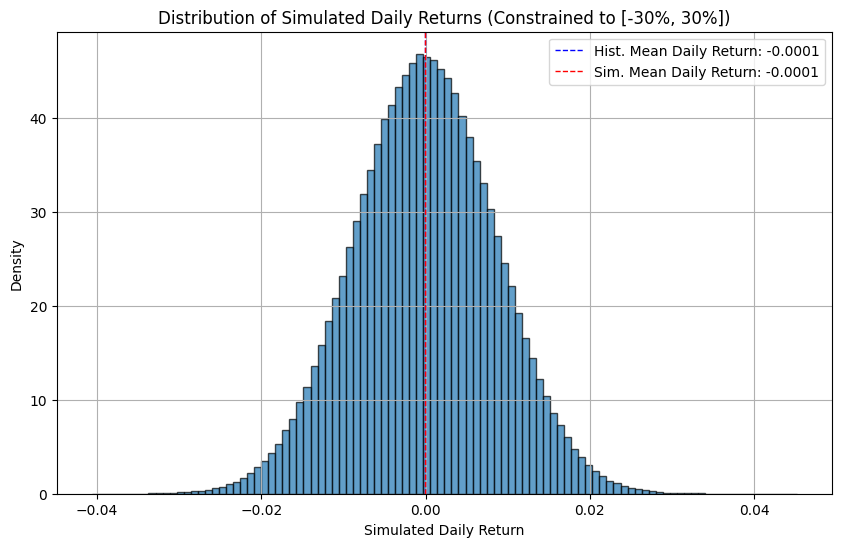


Statistics of simulated prices at the end of year 5 (based on constrained returns):
  Average Price: 686.73
  Median Price: 662.82
  90% Confidence Interval: 408.32 to 1053.89


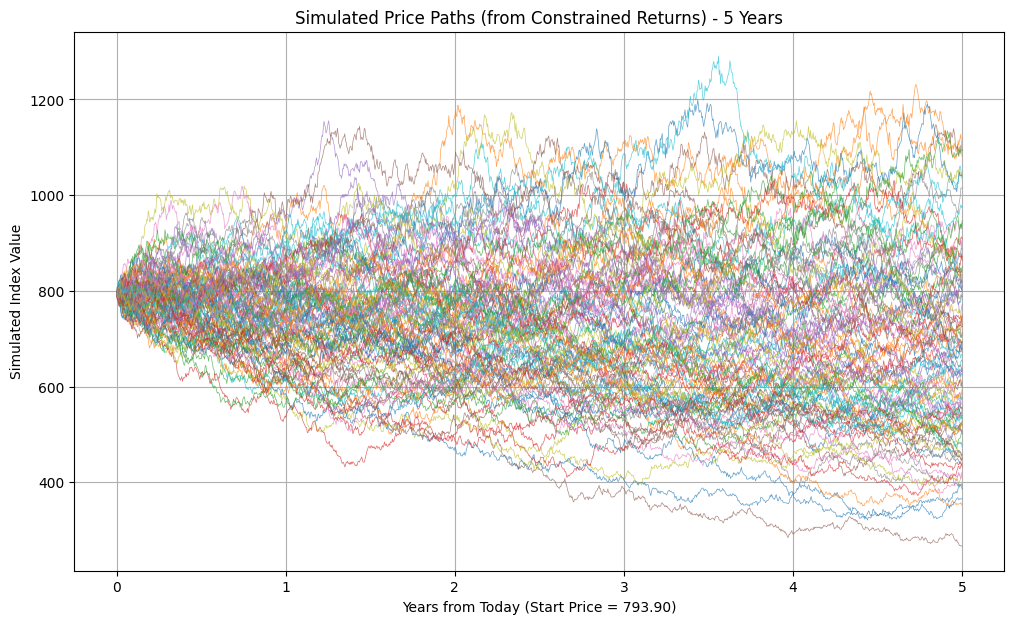

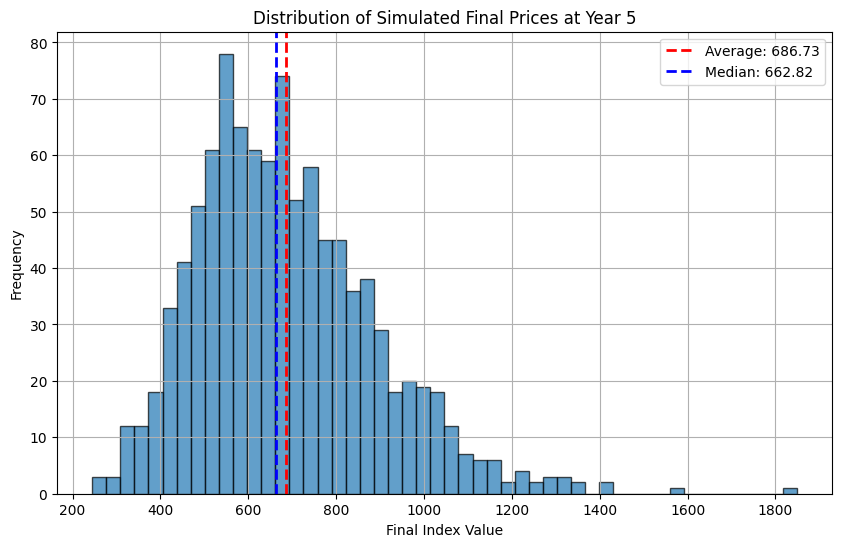

In [6]:
# --- 1. Setup and Data Acquisition ---
def get_historical_data_from_csv(csv_file_path, date_column='Date', price_column='Last'):
    """
    Loads historical closing prices from a CSV file.
    """
    try:
        df = pd.read_csv(csv_file_path, parse_dates=[date_column])
        df = df.set_index(date_column)
        df = df.sort_index()
        prices = df[price_column]
        if prices.dtype == 'object':
            prices = prices.str.replace(',', '', regex=False)
        prices = pd.to_numeric(prices, errors='coerce')
        prices = prices.dropna()
        if prices.empty:
            print(f"No valid price data found in column '{price_column}' after processing.")
            return None
        print(f"Successfully loaded data from {csv_file_path}")
        return prices
    except FileNotFoundError:
        print(f"Error: The file '{csv_file_path}' was not found.")
        return None
    except KeyError as e:
        print(f"Error: Column not found. Ensure '{date_column}' and '{price_column}' are correct. Details: {e}")
        return None
    except Exception as e:
        print(f"An error occurred while reading/processing the CSV: {e}")
        return None

# --- 2. Calculate Historical Return Statistics ---
def calculate_return_statistics(prices):
    """
    Calculates statistics of simple daily returns.
    """
    if not isinstance(prices, pd.Series) or len(prices) < 2:
        print("Error: Input 'prices' must be a pandas Series with at least 2 data points.")
        return None, None, None
    
    # Calculate simple daily returns: (price_t / price_{t-1}) - 1
    simple_daily_returns = prices.pct_change().dropna()

    if simple_daily_returns.empty:
        print("Error: Could not calculate daily returns (need at least 2 distinct dates with prices).")
        return None, None, None

    mean_daily_return = simple_daily_returns.mean()
    std_dev_daily_return = simple_daily_returns.std()
    last_price = prices.iloc[-1]

    if pd.isna(mean_daily_return) or pd.isna(std_dev_daily_return) or pd.isna(last_price):
        print("Error: Calculated return stats or last price is NaN. Check input data.")
        return None, None, None
        
    return mean_daily_return, std_dev_daily_return, last_price

# --- 3. Simulate Constrained Returns and Corresponding Prices ---
def simulate_constrained_returns_and_prices(S0, mean_daily_return, std_dev_daily_return, 
                                            T_years, dt, num_simulations, 
                                            min_return_limit, max_return_limit):
    """
    Simulates daily returns with constraints and calculates corresponding price paths.
    """
    num_steps = int(T_years / dt)
    
    # Arrays to store results
    simulated_daily_returns_log = np.zeros((num_steps, num_simulations))
    price_paths = np.zeros((num_steps + 1, num_simulations))
    price_paths[0, :] = S0

    for t in range(num_steps):
        # Generate random returns based on historical mean and std dev
        random_shocks = np.random.normal(loc=0, scale=1, size=num_simulations)
        daily_sim_returns_unclipped = mean_daily_return + random_shocks * std_dev_daily_return
        
        # Clip the returns to the specified interval
        clipped_daily_sim_returns = np.clip(daily_sim_returns_unclipped, min_return_limit, max_return_limit)
        
        simulated_daily_returns_log[t, :] = clipped_daily_sim_returns
        
        # Calculate new prices based on clipped returns
        price_paths[t+1, :] = price_paths[t, :] * (1 + clipped_daily_sim_returns)
        # Ensure prices don't go below zero (important if returns can be -100% or very large negative)
        price_paths[t+1, :] = np.maximum(0, price_paths[t+1, :])


    return simulated_daily_returns_log, price_paths

# --- Main Settings ---
csv_file_name = 'SET 50 Historical Data (6).csv' 
date_column_name = 'Date'
price_column_name = 'Price'

simulation_horizon_years = 5 
num_simulation_paths = 1000 
trading_days_per_year = 252

# Return constraints
MIN_RETURN = -0.30 # -30%
MAX_RETURN = 0.30  # +30%

# --- Execution ---
print(f"Attempting to load historical data from: {csv_file_name}")
historical_prices = get_historical_data_from_csv(csv_file_name, 
                                                 date_column=date_column_name, 
                                                 price_column=price_column_name)

if historical_prices is not None and not historical_prices.empty:
    print("Historical data (last 5 days):")
    print(historical_prices.tail())

    print("\nCalculating historical daily return statistics...")
    mu_daily, sigma_daily, S0 = calculate_return_statistics(historical_prices)

    if mu_daily is not None and sigma_daily is not None and S0 is not None:
        print(f"Last Price (S0): {S0:.2f}")
        print(f"Mean Daily Return: {mu_daily:.6f} ({(mu_daily*100):.4f}%)")
        print(f"Std Dev of Daily Return: {sigma_daily:.6f} ({(sigma_daily*100):.4f}%)")

        dt = 1/trading_days_per_year

        print(f"\nRunning Monte Carlo simulation for {simulation_horizon_years} years with {num_simulation_paths} paths...")
        print(f"Daily returns will be constrained between {MIN_RETURN*100:.1f}% and {MAX_RETURN*100:.1f}%.")
        
        simulated_returns, simulated_price_paths = simulate_constrained_returns_and_prices(
            S0, mu_daily, sigma_daily, simulation_horizon_years, dt, num_simulation_paths,
            MIN_RETURN, MAX_RETURN
        )

        # --- 4. Displaying Results ---

        # Plotting the distribution of simulated daily returns
        plt.figure(figsize=(10, 6))
        plt.hist(simulated_returns.flatten(), bins=100, edgecolor='black', alpha=0.7, density=True)
        plt.title(f'Distribution of Simulated Daily Returns (Constrained to [{MIN_RETURN*100:.0f}%, {MAX_RETURN*100:.0f}%])')
        plt.xlabel('Simulated Daily Return')
        plt.ylabel('Density')
        plt.axvline(mu_daily, color='blue', linestyle='dashed', linewidth=1, label=f'Hist. Mean Daily Return: {mu_daily:.4f}')
        plt.axvline(simulated_returns.mean(), color='red', linestyle='dashed', linewidth=1, label=f'Sim. Mean Daily Return: {simulated_returns.mean():.4f}')
        plt.legend()
        plt.grid(True)
        plt.show()

        # Plotting the simulated price paths
        plt.figure(figsize=(12, 7))
        num_paths_to_plot = min(100, num_simulation_paths)
        time_axis = np.linspace(0, simulation_horizon_years, simulated_price_paths.shape[0])

        for i in range(num_paths_to_plot):
            plt.plot(time_axis, simulated_price_paths[:, i], lw=0.5, alpha=0.7)

        plt.title(f'Simulated Price Paths (from Constrained Returns) - {simulation_horizon_years} Years')
        plt.xlabel(f'Years from Today (Start Price = {S0:.2f})')
        plt.ylabel('Simulated Index Value')
        plt.grid(True)
        
        final_prices_at_horizon = simulated_price_paths[-1, :]
        avg_final_price = np.mean(final_prices_at_horizon)
        median_final_price = np.median(final_prices_at_horizon)
        percentile_5th = np.percentile(final_prices_at_horizon, 5)
        percentile_95th = np.percentile(final_prices_at_horizon, 95)

        print(f"\nStatistics of simulated prices at the end of year {simulation_horizon_years} (based on constrained returns):")
        print(f"  Average Price: {avg_final_price:.2f}")
        print(f"  Median Price: {median_final_price:.2f}")
        print(f"  90% Confidence Interval: {percentile_5th:.2f} to {percentile_95th:.2f}")
        plt.show()
        
        # Distribution of final prices
        plt.figure(figsize=(10, 6))
        plt.hist(final_prices_at_horizon, bins=50, edgecolor='black', alpha=0.7)
        plt.title(f'Distribution of Simulated Final Prices at Year {simulation_horizon_years}')
        plt.xlabel('Final Index Value')
        plt.ylabel('Frequency')
        plt.axvline(avg_final_price, color='red', linestyle='dashed', linewidth=2, label=f'Average: {avg_final_price:.2f}')
        plt.axvline(median_final_price, color='blue', linestyle='dashed', linewidth=2, label=f'Median: {median_final_price:.2f}')
        plt.legend()
        plt.grid(True)
        plt.show()

    else:
        print("Could not proceed with simulation due to errors in calculating return statistics.")
else:
    print("Cannot proceed with simulation due to issues loading or processing historical data.")